This example shows how to use a `GridInterpolationKernel` module on an `ExactGP` model. This regression module is designed for when the inputs of the function you're modeling are one-dimensional.

The use of inducing points allows for scaling up the training data by making computational complexity linear instead of cubic.

Function to be modeled is  y=sin(4*pi*x)

GridInterpolationKernel exploits the regular grid structure of linspace for Toeplitz covariances.

This notebook doesn't use cuda, in general we recommend GPU use if possible and most of our notebooks utilize cuda as well.

Kernel interpolation for scalable structured Gaussian processes (KISS-GP) was introduced in this paper:
http://proceedings.mlr.press/v37/wilson15.pdf

In [1]:
import math
import torch
import gpytorch
from matplotlib import pyplot as plt
from torch import nn, optim
from torch.autograd import Variable
from gpytorch.kernels import RBFKernel, GridInterpolationKernel
from gpytorch.means import ConstantMean
from gpytorch.likelihoods import GaussianLikelihood
from gpytorch.random_variables import GaussianRandomVariable

# Make plots inline
%matplotlib inline

In [2]:
# Training points are in [0,1] every 1/999
train_x = Variable(torch.linspace(0, 1, 1000))
# Function to model is sin(4*pi*x)
# Gaussian noise from N(0,0.04)
train_y = Variable(torch.sin(train_x.data * (4 * math.pi)) + torch.randn(train_x.size()) * 0.2)

In [3]:
# We use exact GP inference for regression
class GPRegressionModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPRegressionModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = ConstantMean(constant_bounds=[-1e-5,1e-5])
        # Put a grid interpolation kernel over the RBF kernel
        self.base_covar_module = RBFKernel(log_lengthscale_bounds=(-5, 6))
        self.covar_module = GridInterpolationKernel(self.base_covar_module, grid_size=400,
                                                            grid_bounds=[(0, 1)])
        # Register kernel lengthscale as parameter
        self.register_parameter('log_outputscale', nn.Parameter(torch.Tensor([0])), bounds=(-5,6))
        
    def forward(self,x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        covar_x = covar_x.mul(self.log_outputscale.exp())
        return GaussianRandomVariable(mean_x, covar_x)

# The likelihood output is a Gaussian with predictive mean and variance
likelihood = GaussianLikelihood()
# Initialize our model
model = GPRegressionModel(train_x.data, train_y.data, likelihood)

In [4]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iterations = 30
for i in range(training_iterations):
    # Zero backprop gradients
    optimizer.zero_grad()
    # Get output from model
    output = model(train_x)
    # Calc loss and backprop derivatives
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iterations, loss.data[0]))
    optimizer.step()

Iter 1/30 - Loss: 1.138
Iter 2/30 - Loss: 1.156
Iter 3/30 - Loss: 1.173
Iter 4/30 - Loss: 1.192
Iter 5/30 - Loss: 1.211
Iter 6/30 - Loss: 1.231
Iter 7/30 - Loss: 1.252
Iter 8/30 - Loss: 1.274
Iter 9/30 - Loss: 1.293
Iter 10/30 - Loss: 1.305
Iter 11/30 - Loss: 1.308
Iter 12/30 - Loss: 1.295
Iter 13/30 - Loss: 1.265
Iter 14/30 - Loss: 1.220
Iter 15/30 - Loss: 1.170
Iter 16/30 - Loss: 1.128
Iter 17/30 - Loss: 1.097
Iter 18/30 - Loss: 1.078
Iter 19/30 - Loss: 1.068
Iter 20/30 - Loss: 1.065
Iter 21/30 - Loss: 1.069
Iter 22/30 - Loss: 1.077
Iter 23/30 - Loss: 1.090
Iter 24/30 - Loss: 1.106
Iter 25/30 - Loss: 1.125
Iter 26/30 - Loss: 1.147
Iter 27/30 - Loss: 1.172
Iter 28/30 - Loss: 1.199
Iter 29/30 - Loss: 1.229
Iter 30/30 - Loss: 1.261


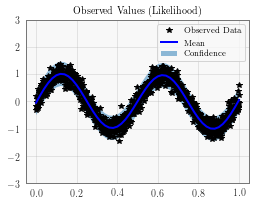

In [5]:
# Put model & likelihood into eval mode
model.eval()
likelihood.eval()

# Initalize plot
f, observed_ax = plt.subplots(1, 1, figsize=(4, 3))
# Test points every 0.02 in [0,1] inclusive
test_x = Variable(torch.linspace(0, 1, 51))

# To make the predictions as accurate as possible, we're going to use lots of iterations of Conjugate Gradients
# This ensures that the matrix solves are as accurate as possible
with gpytorch.settings.max_cg_iterations(100):
    observed_pred = likelihood(model(test_x))

# Define plotting function
def ax_plot(ax, rand_var, title):
    # Get lower and upper predictive bounds
    lower, upper = rand_var.confidence_region()
    # Plot the training data as black stars
    ax.plot(train_x.data.numpy(), train_y.data.numpy(), 'k*')
    # Plot predictive means as blue line
    ax.plot(test_x.data.numpy(), rand_var.mean().data.numpy(), 'b')
    # Plot confidence bounds as lightly shaded region
    ax.fill_between(test_x.data.numpy(), lower.data.numpy(), upper.data.numpy(), alpha=0.5)
    ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    ax.set_title(title)

ax_plot(observed_ax, observed_pred, 'Observed Values (Likelihood)')